In [1]:
!pip install catboost
!pip install xgboost

     -------------------------------------- 101.0/101.0 MB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 99.7/99.7 MB 5.0 MB/s eta 0:00:00


In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [14]:
df = pd.read_excel('data/crime.xlsx')

In [15]:
df.head()

,Unnamed: 0,Case type,Description,People affected,Componseation,Time period,Death
0,1,Money Cheating,Fraud for amount of 4.65 crores,9,46500000,17.0,0
1,2,Murder,Murder case with high court involvement,4,0,29.0,3
2,3,Murder,Murder case with high court involvement,3,0,25.0,1
3,4,Murder,Murder case with high court involvement,3,0,16.0,1
4,5,Suo Moto,Criminal Case,13000000,0,0.0,0


In [33]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0         0
Case type          0
Description        0
People affected    0
Componseation      0
Time period        0
Death              0
Priority Score     0
dtype: int64

In [34]:
weights = {
    'People affected': 0.25,
    'Componseation': 0.25,
    'Time period': 0.25,
    'Death': 0.25
}

# Convert columns to numeric (excluding non-numeric columns)
numeric_columns = ['People affected', 'Componseation', 'Time period', 'Death']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Replace any remaining non-numeric values with NaN
df[numeric_columns] = df[numeric_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Normalize each column (including the scaled columns) by dividing by its maximum value
for column in numeric_columns:
    df[column] = df[column] / df[column].max()

# Calculate the "Priority Score" for each row
df['Priority Score'] = df.apply(lambda row: sum(row[column] * weights[column] for column in weights), axis=1)

# Rescale "Priority Score" to the range of 0 to 10
min_score = df['Priority Score'].min()
max_score = df['Priority Score'].max()
df['Priority Score'] = 0 + (df['Priority Score'] - min_score) * (10 - 0) / (max_score - min_score)

# Print the DataFrame with the new "Priority Score" column
print(df)


    Unnamed: 0                         Case type  \
0            1                    Money Cheating   
1            2                            Murder   
2            3                            Murder   
3            4                            Murder   
4            5                          Suo Moto   
..         ...                               ...   
95          96  Brij Lal & Ors. v. State of U.P.   
96          97                     Factory Blast   
97          98             Involment in gambling   
98          99      Union India vs Kuldeep singh   
99         100        Provding fake medical kits   

                                          Description  People affected  \
0                     Fraud for amount of 4.65 crores     2.000000e-08   
1             Murder case with high court involvement     8.888889e-09   
2             Murder case with high court involvement     6.666667e-09   
3             Murder case with high court involvement     6.666667e-09   
4    

In [35]:
df.head()

,Unnamed: 0,Case type,Description,People affected,Componseation,Time period,Death,Priority Score
0,1,Money Cheating,Fraud for amount of 4.65 crores,2.000000e-08,0.3875,0.586207,0.000000,5.214171
1,2,Murder,Murder case with high court involvement,8.888889e-09,0.0000,1.000000,0.057692,5.664939
2,3,Murder,Murder case with high court involvement,6.666667e-09,0.0000,0.862069,0.019231,4.718201
3,4,Murder,Murder case with high court involvement,6.666667e-09,0.0000,0.551724,0.019231,3.052513
4,5,Suo Moto,Criminal Case,2.888889e-02,0.0000,0.000000,0.000000,0.143126


In [36]:
X = df.drop(['Priority Score','Description'],axis=1)

In [37]:
X.head()

,Unnamed: 0,Case type,People affected,Componseation,Time period,Death
0,1,Money Cheating,2.000000e-08,0.3875,0.586207,0.000000
1,2,Murder,8.888889e-09,0.0000,1.000000,0.057692
2,3,Murder,6.666667e-09,0.0000,0.862069,0.019231
3,4,Murder,6.666667e-09,0.0000,0.551724,0.019231
4,5,Suo Moto,2.888889e-02,0.0000,0.000000,0.000000


In [38]:
Y = df['Priority Score']

In [39]:
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns


numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
# the below code is responsible for transforming the columns
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [40]:
X = preprocessor.fit_transform(X)


In [41]:
X.shape


(99, 59)

In [42]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.1,random_state=42)
X_train.shape, X_test.shape

((89, 59), (10, 59))

In [43]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [44]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0000
- Mean Absolute Error: 0.0000
- R2 Score: 1.0000


Lasso
Model performance for Training set
- Root Mean Squared Error: 1.6875
- Mean Absolute Error: 1.1821
- R2 Score: 0.0345
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.4584
- Mean Absolute Error: 1.1452
- R2 Score: 0.0114


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.0208
- Mean Absolute Error: 0.0145
- R2 Score: 0.9999
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.0469
- Mean Absolute Error: 0.0392
- R2 Score: 0.9990


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.8984
- Mean Absolute Error: 0.4245
- R2 Score: 0.7264
-----------------------

In [45]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,1.000000
2,Ridge,0.998979
7,CatBoosting Regressor,0.828662
4,Decision Tree,0.785421
6,XGBRegressor,0.736466
5,Random Forest Regressor,0.694687
3,K-Neighbors Regressor,0.470519
8,AdaBoost Regressor,0.466059
1,Lasso,0.011352


In [46]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 100.00


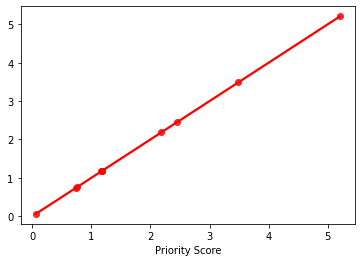

In [47]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

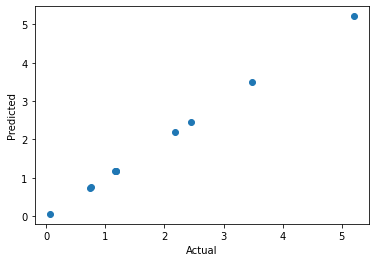

In [48]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');